In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import colorsys

In [2]:
# Desaturate a color by a given amount.
# Tune this later to make the plot prettier

def desaturate(color, amount):
	r, g, b = color
	h, l, s = colorsys.rgb_to_hls(r, g, b)
	s = max(0, s - amount)
	return colorsys.hls_to_rgb(h, l, s)

In [3]:
# State geometries from shapefiles can be messy! 
# We only want to colour in the largest polygon, which this function identifies

def get_largest_geom(group):
	projected_group = group.to_crs(epsg=32644)  # Reproject to UTM Zone 44N
	return group.loc[projected_group.geometry.area.idxmax()]

In [4]:
# Converts the original geodataframe into one containing only those largest geometries

def prepare_merged_gdf(results_df):
	results_df['State'] = results_df['State'].str.replace('_', ' ').str.replace(' and ', ' & ')
	
	# Handle specific cases like Jammu & Kashmir splitting into Jammu & Kashmir and Ladakh
	ladakh_data = results_df[results_df['State'] == 'Jammu & Kashmir'].copy()
	ladakh_data['State'] = 'Ladakh'
	results_df = pd.concat([results_df, ladakh_data])
	
	# Merge the geo-dataframe with the results dataframe on the 'State' column
	merged = pd.merge(gdf, results_df, left_on='ST_NM', right_on='State', how='left')

	# Calculate the largest geometry for plotting
	merged = merged.groupby('ST_NM').apply(get_largest_geom).reset_index(drop=True)
	
	# Calculate r2 for plotting
	merged['r2'] = merged['R Value']**2
		
	return merged

In [5]:
# Load the shapefile with geopandas
gdf = gpd.read_file("../other-files/india_states.shp")

In [6]:
# Load the individual model results into a pandas dataframe
merged_xg = prepare_merged_gdf(pd.read_csv("outputs/model_results_xg.csv"))
merged_nn = prepare_merged_gdf(pd.read_csv("outputs/model_results_nn.csv"))
merged_mlr = prepare_merged_gdf(pd.read_csv("outputs/model_results_linear_regression.csv"))

/tmp/ipykernel_16039/2140344078.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby('ST_NM').apply(get_largest_geom).reset_index(drop=True)
/tmp/ipykernel_16039/2140344078.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = merged.groupby('ST_NM').apply(get_largest_geom).reset_index(drop=True)
/tmp/ipykernel_16039/2140344078.py:13: DeprecationWarning: DataFrameGroupBy.appl

In [7]:
# Calculate mean and median r^2 for each model
mean_r2_xg = merged_xg['r2'].mean()
median_r2_xg = merged_xg['r2'].median()

mean_r2_nn = merged_nn['r2'].mean()
median_r2_nn = merged_nn['r2'].median()

mean_r2_mlr = merged_mlr['r2'].mean()
median_r2_mlr = merged_mlr['r2'].median()

# Print the results
print(f"XGBoost Model - Mean r^2: {mean_r2_xg:.2f}, Median r^2: {median_r2_xg:.2f}")
print(f"NN Model - Mean r^2: {mean_r2_nn:.2f}, Median r^2: {median_r2_nn:.2f}")
print(f"Linear Regression Model - Mean r^2: {mean_r2_mlr:.2f}, Median r^2: {median_r2_mlr:.2f}")

XGBoost Model - Mean r^2: 0.70, Median r^2: 0.78
NN Model - Mean r^2: 0.59, Median r^2: 0.63
Linear Regression Model - Mean r^2: 0.46, Median r^2: 0.50


In [8]:
all_models = pd.concat([
	merged_xg[['State', 'r2']].assign(Model='XGBoost'),
	merged_nn[['State', 'r2']].assign(Model='NN'),
	merged_mlr[['State', 'r2']].assign(Model='Linear Regression')
])

# Aggregate data to ensure no duplicates
all_models_agg = all_models.groupby(['State', 'Model'], as_index=False).agg({'r2': 'mean'})

# Pivot the table to get r^2 scores for each model by state
pivoted = all_models_agg.pivot(index='State', columns='Model', values='r2')

# Print the results in the desired format
print("State,Skill_XGBoost,Skill_NN,Skill_MLR")
for state, row in pivoted.iterrows():
	skill_xgboost = row.get('XGBoost', 'N/A')
	skill_nn = row.get('NN', 'N/A')
	skill_mlr = row.get('Linear Regression', 'N/A')
	print(f"{state},{skill_xgboost},{skill_nn},{skill_mlr}")

State,Skill_XGBoost,Skill_NN,Skill_MLR
Andhra Pradesh,0.8078129763072983,0.64952937329213,0.508078698211343
Arunachal Pradesh,0.2281690062210944,0.2052780286080705,0.09521214967574865
Assam,0.8205316914351789,0.7398391468826258,0.5937038073508397
Bihar,0.555807794691975,0.32636141722776196,0.24698721590113018
Chandigarh,0.9504133061401849,0.9329388368153629,0.7063732890430062
Chhattisgarh,0.8247644192740753,0.668331767079704,0.47979192442064145
Goa,0.5331435862730655,0.41746852940288653,0.3337486523225122
Gujarat,0.8443419113028844,0.6268846657679397,0.4573713262582491
Haryana,0.9286051609368021,0.8933752704979089,0.6411314254841681
Himachal Pradesh,0.42631169230021293,0.3384422919718736,0.13180313645391734
Jammu & Kashmir,0.6520950037959722,0.5191246917032648,0.5079008648154703
Jharkhand,0.41559773747103634,0.2986081245158406,0.1083079248051486
Karnataka,0.866988805369832,0.7185407532989794,0.6686275164324689
Kerala,0.8348108244153831,0.7510844455285768,0.6797385242638884
Ladakh,0.652

In [13]:
%matplotlib inline
plt.ioff()


# Set up the plot
fig = plt.figure(figsize=(8, 16))
gs = fig.add_gridspec(nrows=3, ncols=2, top=0.95, bottom=0.1, wspace=0, hspace=0.29, right=0.85)
ax1 = fig.add_subplot(gs[:2,:])
ax2 = fig.add_subplot(gs[2,0])
ax3 = fig.add_subplot(gs[2,1])

axs = ax1, ax2, ax3

# Custom colormap
colors = [
	"white",
	"lightgrey",
	"grey",
	desaturate((1.0, 1.0, 0.5), 0.2),  # light yellow
	desaturate((1.0, 1.0, 0.0), 0.2),  # yellow
	desaturate((1.0, 0.8, 0.0), 0.2),  # orange-yellow
	desaturate((1.0, 0.4, 0.0), 0.2),  # orange
	desaturate((1.0, 0.0, 0.0), 0.2)   # red
]
cmap = ListedColormap(colors)
boundaries = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

left, bottom, width, height = ax1.get_position().bounds
cbar_ax = fig.add_axes([0.875, bottom, 0.03, height])

In [14]:
# Plot the maps
titles = ['(a) XGBoost', '(b) 3-layer dense NN', '(c) multivariate linear regression']
for ax, data, title in zip(axs, [merged_xg, merged_nn, merged_mlr], titles):
	cs = data.plot(column='r2', ax=ax, legend=False, cmap=cmap, norm=norm)
	data.boundary.plot(ax=ax, linewidth=0.1, color='black')
	ax.set_title(title)


plt.colorbar(cs.collections[0], cax=cbar_ax, label="Model r$^2$ value by state", extend='min')

In [11]:
# Plot the maps
titles = ['(a) XGBoost', '(b) 3-layer dense NN', '(c) multivariate linear regression']
for ax, data, title in zip(axs, [merged_xg, merged_nn, merged_mlr], titles):
	cs = data.plot(column='r2', ax=ax, legend=False, cmap=cmap, norm=norm)
	data.boundary.plot(ax=ax, linewidth=0.1, color='black')
	ax.set_title(title)


plt.colorbar(cs.collections[0], cax=cbar_ax, label="Model r$^2$ value by state", extend='min')

In [15]:
# Only add text to the first plot
offsets = {
	'Nagaland': (1, 0),		   
	'Punjab': (-1, 0),			
	'Mizoram': (0, -1),		  
	'NCT of Delhi': (0.5, -0.5),  
	'Jammu & Kashmir': (2, 1),
	'West Bengal': (0,-1),
	'Arunachal Pradesh': (0, 0.5),
	'Himachal Pradesh': (1, 0),
	'Andhra Pradesh': (0, -0.5),
	'Haryana': (-0.25, 0),
	'Meghalaya': (0, -0.25),
	'Uttarakhand': (0.5, 0),
	
}

texts = []
for x, y, stnm, r2 in zip(merged_xg.centroid.x, merged_xg.centroid.y, merged_xg['State'], merged_xg['r2']):
	if stnm not in [np.nan, 'Ladakh']:
		offset = offsets.get(stnm, (0, 0))
		x += offset[0]
		y += offset[1]
		texts.append(axs[0].text(x, y, f"{stnm}\n({r2:.2f})", fontsize=6, ha='center', va='center'))


/tmp/ipykernel_16039/1025792081.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(y_labels)
/tmp/ipykernel_16039/1025792081.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_labels)
/tmp/ipykernel_16039/1025792081.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


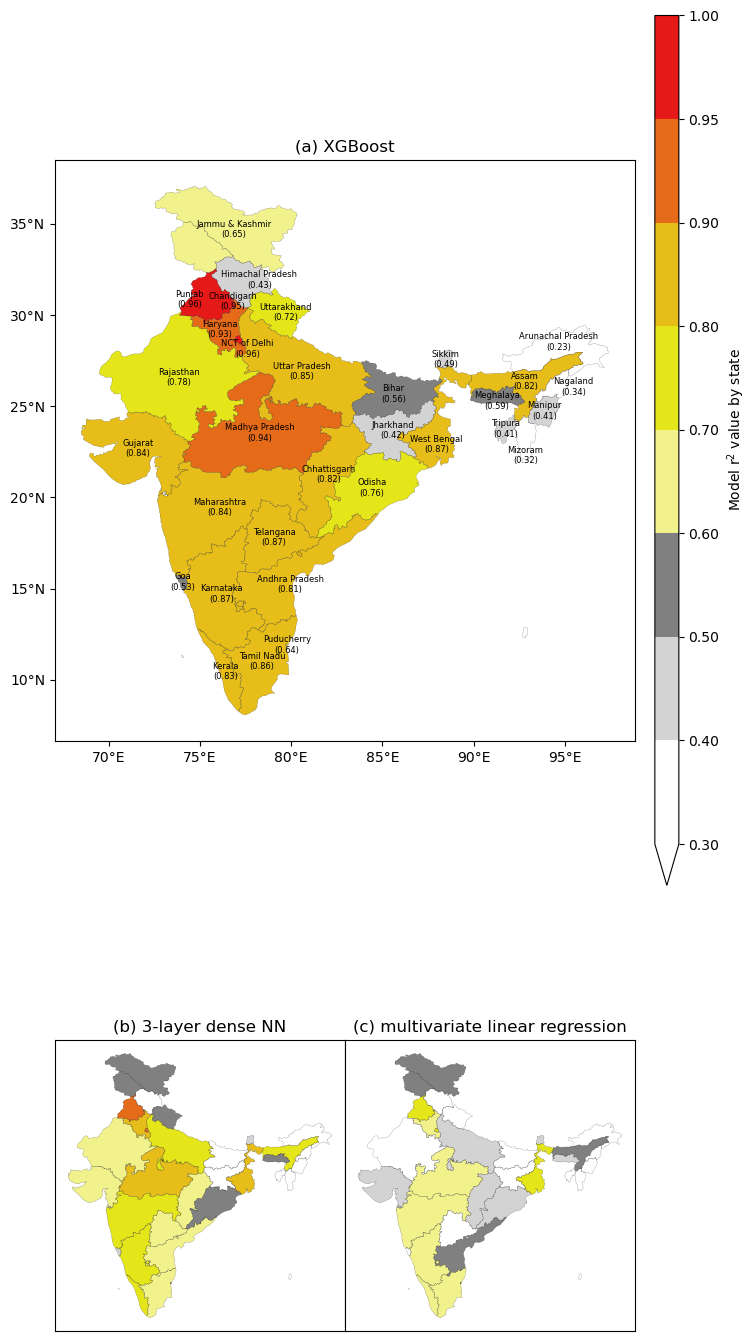

In [16]:
# Format the axes
y_labels = [f"{int(label)}°N" if label > 0 else f"{int(-label)}°S" for label in ax1.get_yticks()]
ax1.set_yticklabels(y_labels)
x_labels = [f"{int(label)}°E" if label > 0 else f"{int(-label)}°W" for label in ax1.get_xticks()]
ax1.set_xticklabels(x_labels)

for ax in ax2, ax3:
	ax.set_yticks([])
	ax.set_xticks([])

for ax in axs:
	ax.set_aspect('equal')

# Adjust layout
plt.tight_layout()
plt.show()
